# Random Forest cut selection

We aim to select the best cut for our analysis.
Best refers to a resulting selection with high purity and low uncertainty.
Purity is defined as the fraction of signal events to the total number of events in the final selection.
Uncertainty in this case is taken from a sub set of the full list of uncertainties "measured" for this analysis.
They are Jet scale, Statistical and Background Normalization uncertainty. 
We chose these uncertainties because they are large and most affected by changes to kinematic cuts.
The Uncertainty is taken as the the sum of the list above in quadrature.

Purity
$$p = \frac{N_{\mathrm{sig}}}{N_{\mathrm{sig}} + N_{\mathrm{bg}}}$$

Uncertainty
$$U = \sqrt{ \sum \sigma_{\mathrm{i}}^2 }$$

In [1]:
#Set up
import os, sys
sys.path.append(os.getcwd() + "/../")
from prep_ana_II import *
sys.path.append(os.getcwd() + "/../tools/")
sys.path.append(os.getcwd() + "/../tools/jecsys/")
from JECUncertainty import JECUncertainty, jecUncertainties
from lepton_eff import muonEff, electronEff
from cross_section_calc import calc_cross_stuff, cross_calc, stat_unc_calc, normalization_unc_calc

import warnings
warnings.filterwarnings('ignore')

Welcome to JupyROOT 6.10/00
home /home/gunter/WW_analysis/production/Analysis_13TeV
Loading binning options...
Loading plotting options
unc_mc_process and scales are parameter dictionaries


In [2]:
#Load MC and random forest
scales, df = load_testset() 

rfs = load_randomForest()

fDY = rfs["clf_fDY"]
fTT = rfs["clf_fTT"]

features_fDY = rfs["features_fDY"]
features_fTT = rfs["features_fTT"]

## Flavored scores

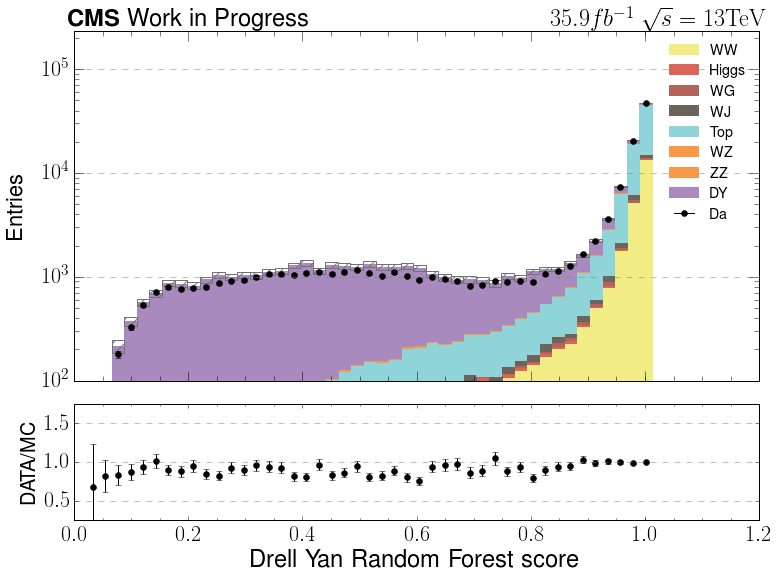

In [3]:
df_da = load_presel_w_fDY_fTT_DATA()
full_bin_plot(pre_cuts(df), pre_cuts(df_da), "pred_fDY_WW", query="lep_Type > 0", scales=scales)
plt.show()

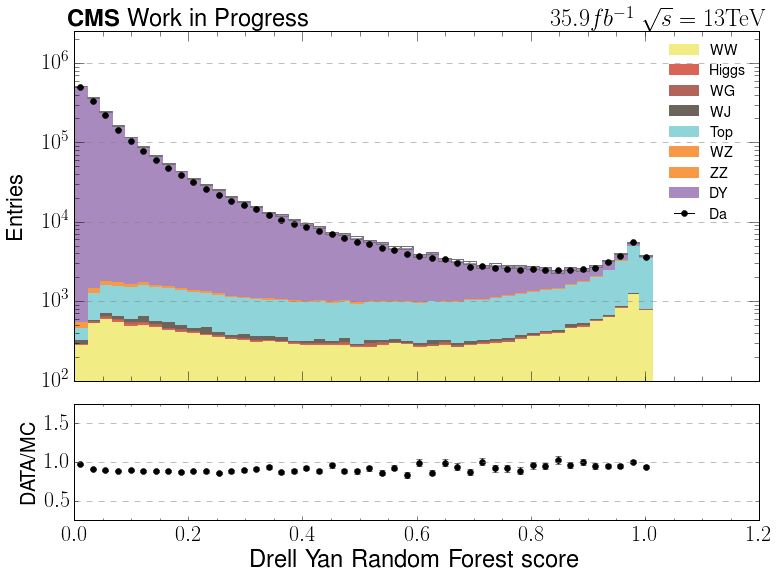

In [4]:
full_bin_plot(pre_cuts(df), pre_cuts(df_da), "pred_fDY_WW", query="lep_Type < 0", scales=scales)
plt.show()

## Forest scores


### Purity

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 26})

In [8]:
def purity(fdy, ftt, df=df, scales=scales):
    table = process_yields(df[(df.pred_fDY_WW > fdy) & (df.pred_fTT_WW > ftt) & (df.lep1_Charge != df.lep2_Charge)], scales=scales)
    signal = table[table.Process == "Total: WW"]["Diff Flavor"].values[0] + table[table.Process == "Total: WW"]["Same Flavor"].values[0]
    total = table[table.Process == "Total"]["Diff Flavor"].values[0] + table[table.Process == "Total"]["Same Flavor"].values[0]
    
    return float(signal) / total

In [9]:
#Construct Purity array
purity_array = []
nbins = 20
for _fdy in range(0, nbins):
    purity_array.append([])
    for _ftt in range(0,nbins):
        fdy = float(_fdy) / nbins
        ftt = float(_ftt) / nbins
        p = purity(fdy, ftt)
        #print _fdy, _ftt, p
        purity_array[_fdy].append( p )
        
purity_array = np.array(purity_array)

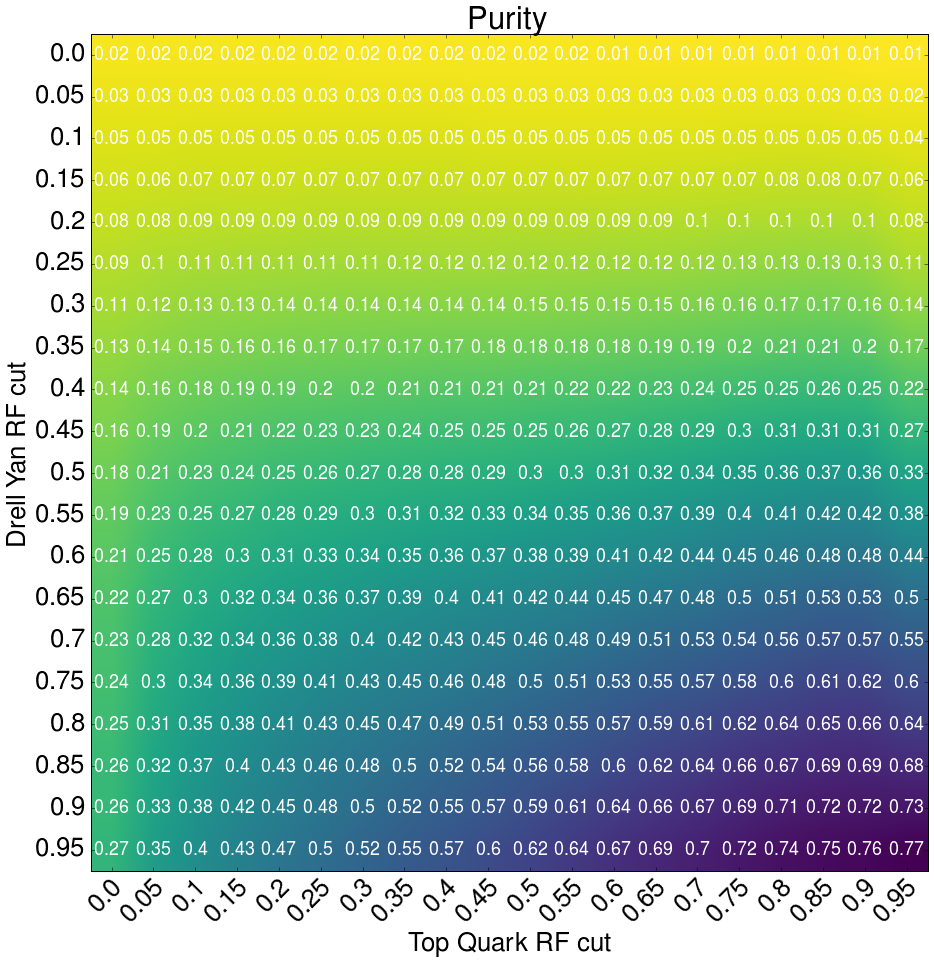

In [10]:
#Purity with lables
plt.figure(figsize=(15,15))
plt.imshow(purity_array, cmap='viridis_r')
for i in range(purity_array.shape[0]):
    for j in range(purity_array.shape[1]):
        text = plt.text(j, i, round(purity_array[i, j], 2),
                       ha="center", va="center", color="w", fontsize=18)
locs, labels= plt.xticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.title("Purity")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.show()

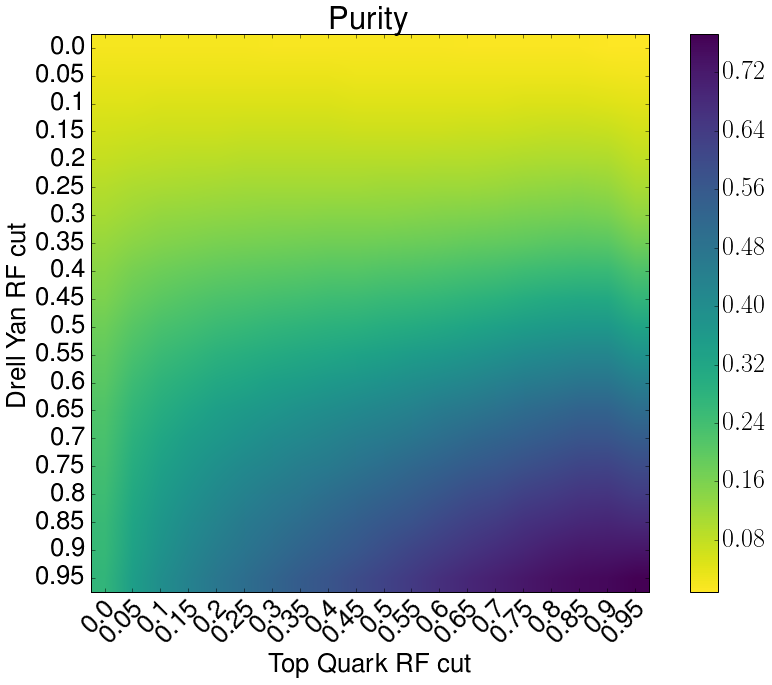

In [11]:
#Purity without lables
plt.figure(figsize=(15,10))
plt.imshow(purity_array, cmap='viridis_r')
plt.colorbar()

locs, labels= plt.xticks(np.arange(20), [float(i) / 20. for i in range(20)])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(20), [float(i) / 20. for i in range(20)])
plt.title("Purity")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.savefig("/home/gunter/WW_analysis/PAPER/myDir/notes/AN-17-169/trunk/FIGS/plots/rf_purity.pdf")
plt.show()

### Uncertainty

stat + background + jet_scale

In [125]:
def norm_calc(df, ratio):

    cuts_mc = {process: df[(df.process_decay == process) & (df.lep1_Charge != df.lep2_Charge)] for process in scales.keys()}
    process_sys_unc = []
    temp_diboson = 0

    for process in cuts_mc.keys():
        if process not in ['WW', 'GluGluWWTo2L2Nu']:#, 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W4JetsToLNu']:
            if process in ["WZ", "ZZ",]:
                temp_diboson = temp_diboson + (unc_mc_process[process] * scales[process]) * cuts_mc[process].shape[0]
            else:
                process_sys_unc.append((unc_mc_process[process]**2 * scales[process])**2 * cuts_mc[process].shape[0]**2)

    process_sys_unc.append(temp_diboson**2)
    return 1. / (36*10e3 * 0.1 * ratio )  * sum(process_sys_unc)**.5

In [132]:
def temp_unc(query, df=df):
    ratio = (df.query(query + " & process_decay == 'WW'").shape[0] * scales["WW"] +\
            df.query(query + " & process_decay == 'GluGluWWTo2L2Nu'").shape[0] * scales["GluGluWWTo2L2Nu"]) /\
            (df.query("process_decay == 'WW'").shape[0] * scales["WW"] +\
            df.query("process_decay == 'GluGluWWTo2L2Nu'").shape[0] * scales["GluGluWWTo2L2Nu"])

    normalization = norm_calc(df.query(query), ratio)
    temp = []
    for process in df.query(query).process_decay.unique():
        temp.append(scales[process]**2. * df.query(query + " & process_decay == '" + process + "'").shape[0])
    stat = 1. / (36*10e3 * 0.1 * ratio) * sum(temp)**.5
    return normalization, stat

In [139]:
#Making unc (Stat + Norm) arrays
unc_stat_array = []
unc_norm_array = []
nbins = 20

for _fdy in range(0, nbins):
    unc_stat_array.append([])
    unc_norm_array.append([])
    for _ftt in range(0,nbins):
        fdy = float(_fdy) / nbins
        ftt = float(_ftt) / nbins        
        _norm, _stat = temp_unc("pred_fDY_WW > " + str(fdy) + " & " + "pred_fTT_WW > " + str(ftt))
        unc_stat_array[_fdy].append(_stat)
        unc_norm_array[_fdy].append(_norm)

unc_stat_array = np.array(unc_stat_array)
unc_norm_array = np.array(unc_norm_array)

In [153]:
def loadJECUnc():
    JECUnc = pickle.load(open("/home/gunter/WW_analysis/production/Analysis_13TeV/scripts/uncertainties_dir/data/jecDump.pkl", "r"))
    return JECUnc
    

def apply_binned_jet_uncertainty( df, bins, pt_bins, eta_bins):
  #Apply binned uncertainty to WW and see how jet bin hist change
  #bins, pt_bins, eta_bins

  for k in df.keys():
    if "jet" in k and "eta" in k:
      df[ k[:-3]+"unc"] = 0.

  pt_ = 30
  for it, pt in enumerate(pt_bins):
    #print "pt:", pt_, pt_ + pt
    eta_ = -5
    for jt, eta in enumerate(eta_bins):
      #print "eta:", eta_, eta_ + eta
      for k in df.keys():
        if "jet" in k and "eta" in k:
          if pt_ == 30:
            selection = (df[k[:-3] + "pt"] >= 20.) &\
                        (df[k[:-3] +"pt"] < pt_ + pt) &\
                        (df[k] >= eta_) &\
                        (df[k] < eta_ + eta)
          else:
            selection = (df[k[:-3] + "pt"] >= pt_) &\
                        (df[k[:-3] +"pt"] < pt_ + pt) &\
                        (df[k] >= eta_) &\
                        (df[k] < eta_ + eta)
          df[k[:-3]+"unc"].values[selection] = bins[it][jt]

      eta_ += eta
    pt_ += pt


In [156]:
def jet_scale_shift_official(data, pt_cut=30, up_down="up", rf=None):
  #?Is this working as advertized
  vec_ht_values_sin_orig = copy.copy(data.HT.values) * 0
  vec_ht_values_cos_orig = copy.copy(data.HT.values) * 0

  vec_ht_values_sin_post = copy.copy(data.HT.values) * 0
  vec_ht_values_cos_post = copy.copy(data.HT.values) * 0


  if "jet1_unc" not in data.keys():
    print data.keys()
    print "\033[1mJet1 unc is not available...\033[0m"
  ht_values = copy.copy(data.HT.values)
  data.HT = data.HT * 0
  #Scale pt of each jet
  if up_down == "up":
    thingoo = 1
  else:
    thingoo = -1
  for k in data.keys():
    if "bjet" in k: continue
    if "jet" in k and "unc" in k: 
  
      #Original vec_ht values Energy scale  
      vec_ht_values_sin_orig += data[k[:4] + "_pt"] * np.sin(data[k[:4] + "_phi"]) 
      vec_ht_values_cos_orig += data[k[:4] + "_pt"] * np.cos(data[k[:4] + "_phi"])
      
  
      data[k[:-3]+"pt"] = data[k[:-3]+"pt"] * np.abs(thingoo + data[k])
  #######?Same loop maybe
  for k in data.keys():
    if "jet" in k and "pt" in k:
      ht_lost_jet = data[k] >= pt_cut
      data.HT.values[ht_lost_jet] = data[ht_lost_jet].HT.values + data[ht_lost_jet][k].values 

      #Post uncertainty corrected  vec_ht values 
      vec_ht_values_sin_post += data[k] * np.sin(data[k[:4] + "_phi"])
      vec_ht_values_cos_post += data[k] * np.cos(data[k[:4] + "_phi"])
      #print "SIN STUFF", k,  np.sin(data[data[k[:4] + "_pt"] > 0][k[:4] + "_phi"].values[:5])


  #MET results
  #?met projected isn't right need to change
  previous_met = copy.copy(data.metMod.values )
  data.metMod  = np.sqrt( (data.metMod * np.sin(data.met_phi) - vec_ht_values_sin_orig + vec_ht_values_sin_post )**2 +\
                          (data.metMod * np.cos(data.met_phi) - vec_ht_values_cos_orig + vec_ht_values_cos_post )**2 )
  data.METProj = data.metMod.values / previous_met * data.METProj # np.abs(data.METProj - (ht_values - data.HT))
  data.recoil  = np.sqrt( (data.metMod * np.sin(data.met_phi) + data.lep1_pt * np.sin(data.lep1_phi) + data.lep2_pt * np.sin(data.lep2_phi))**2 +\
                          (data.metMod * np.cos(data.met_phi) + data.lep1_pt * np.cos(data.lep1_phi) + data.lep2_pt * np.cos(data.lep2_phi))**2 )
  #Update number of jets
  kill_jets( data, pt_cut )

  #Add dPhiXJet stuff 
  data.dPhiMETJet.values[data.numb_jets.values == 0] = -1
  data.dPhiLLJet.values[data.numb_jets.values == 0] = -1


  if rf != None:
  #print "Recreating random forest scores."
    pred_fTT = rf["clf_fTT"].predict_proba(np.float32(data[rf["features_fTT"]].values))
    data["fTT"] = pred_fTT[:,0]

    temp = data[rf["features_fDY"]]
    temp = temp.replace([np.inf,-np.inf], 0)
    pred_fDY = rf["clf_fDY"].predict_proba(np.float32(temp.values))
    data["fDY"] = pred_fDY[:,0]

def kill_jets( df, pt_cut=30 ):
  """
  Edit number of jets in event based on pt cut
  """
  #?Not quite what I should be doing..
  n_jets = np.zeros(df.shape[0]) #np.maximum(np.zeros(df.shape[0]), df.numb_jets.values - 6)
  for k in df.keys():
    if "jet" in k and "pt" in k:
      cut = (df[k] > pt_cut)
      n_jets[cut.values] = n_jets[cut.values] + 1

  df["numb_jets"] = n_jets


In [184]:
####
def thingoo(fdy, dtt, df):
    table = process_yields(df[(df.pred_fDY_WW > fdy) & (df.pred_fTT_WW > ftt) & (df.lep1_Charge != df.lep2_Charge)], scales=scales)

    signal = table[table.Process == "Total: WW"]["Diff Flavor"].values[0] + table[table.Process == "Total: WW"]["Same Flavor"].values[0]
    total = table[table.Process == "Total"]["Diff Flavor"].values[0] + table[table.Process == "Total"]["Same Flavor"].values[0]
    bkg = total - signal
    ratio = signal / (df.query("process_decay == 'WW'").shape[0] * scales["WW"] +\
            df.query("process_decay == 'GluGluWWTo2L2Nu'").shape[0] * scales["GluGluWWTo2L2Nu"])
    return bkg / (36e3 * 0.1 * ratio)
####

JECUnc = loadJECUnc()
jet_nominal_array = []
nbins = 20
for _fdy in range(0, nbins):
    jet_nominal_array.append([])
    for _ftt in range(0,nbins):
        fdy = float(_fdy) / nbins
        ftt = float(_ftt) / nbins
        nominal = thingoo(fdy, ftt, df)
        jet_nominal_array[_fdy].append(nominal)


apply_binned_jet_uncertainty(df, JECUnc["bins"], JECUnc["pt_bins"], JECUnc["eta_bins"])
jet_scale_shift_official(df, rf=rfs, up_down="up")

df["pred_fTT_WW"] = df.fTT
df["pred_fDY_WW"] = df.fDY

jet_up_array = []
for _fdy in range(0, nbins):
    jet_up_array.append([])
    for _ftt in range(0,nbins):
        fdy = float(_fdy) / nbins
        ftt = float(_ftt) / nbins
        up = thingoo(fdy, ftt, df)
        jet_up_array[_fdy].append(up)
        
scales, df = load_testset()

apply_binned_jet_uncertainty(df, JECUnc["bins"], JECUnc["pt_bins"], JECUnc["eta_bins"])
jet_scale_shift_official(df, rf=rfs, up_down="down")

df["pred_fTT_WW"] = df.fTT
df["pred_fDY_WW"] = df.fDY

jet_down_array = []
for _fdy in range(0, nbins):
    jet_down_array.append([])
    for _ftt in range(0,nbins):
        fdy = float(_fdy) / nbins
        ftt = float(_ftt) / nbins
        down = thingoo(fdy, ftt, df)
        jet_down_array[_fdy].append(down)
        
scales, df = load_testset()

jet_down_array = np.array(jet_down_array)
jet_up_array = np.array(jet_up_array)
jet_array = np.abs(jet_down_array - jet_up_array) / 2.

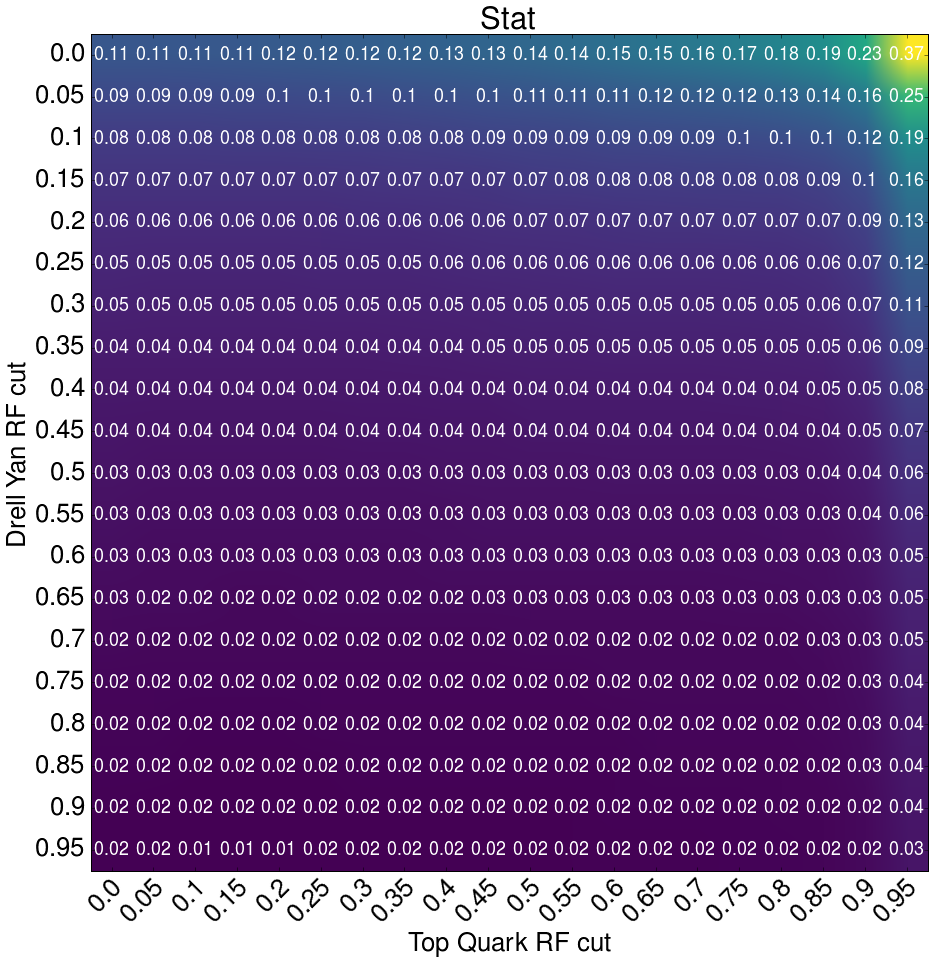

In [148]:
#Stat plot
plt.figure(figsize=(15,15))
plt.imshow(unc_stat_array, cmap='viridis')
for i in range(unc_stat_array.shape[0]):
    for j in range(unc_stat_array.shape[1]):
        text = plt.text(j, i, round(unc_stat_array[i, j], 2),
                       ha="center", va="center", color="w", fontsize=18)
locs, labels= plt.xticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.title("Stat")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.show()

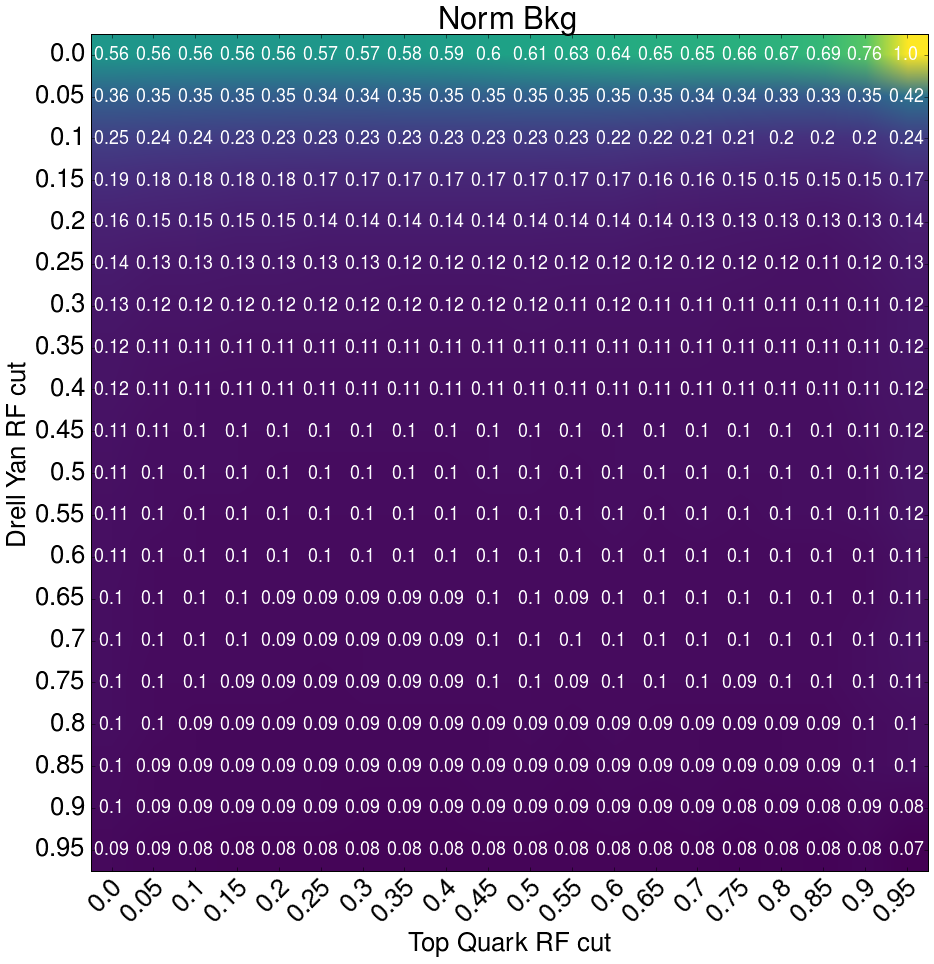

In [149]:
#Norm plot
plt.figure(figsize=(15,15))
plt.imshow(unc_norm_array / unc_norm_array.max(), cmap='viridis')
for i in range(unc_norm_array.shape[0]):
    for j in range(unc_norm_array.shape[1]):
        text = plt.text(j, i, round(unc_norm_array[i, j] / unc_norm_array.max(), 2),
                       ha="center", va="center", color="w", fontsize=18)
locs, labels= plt.xticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.title("Norm Bkg")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.show()

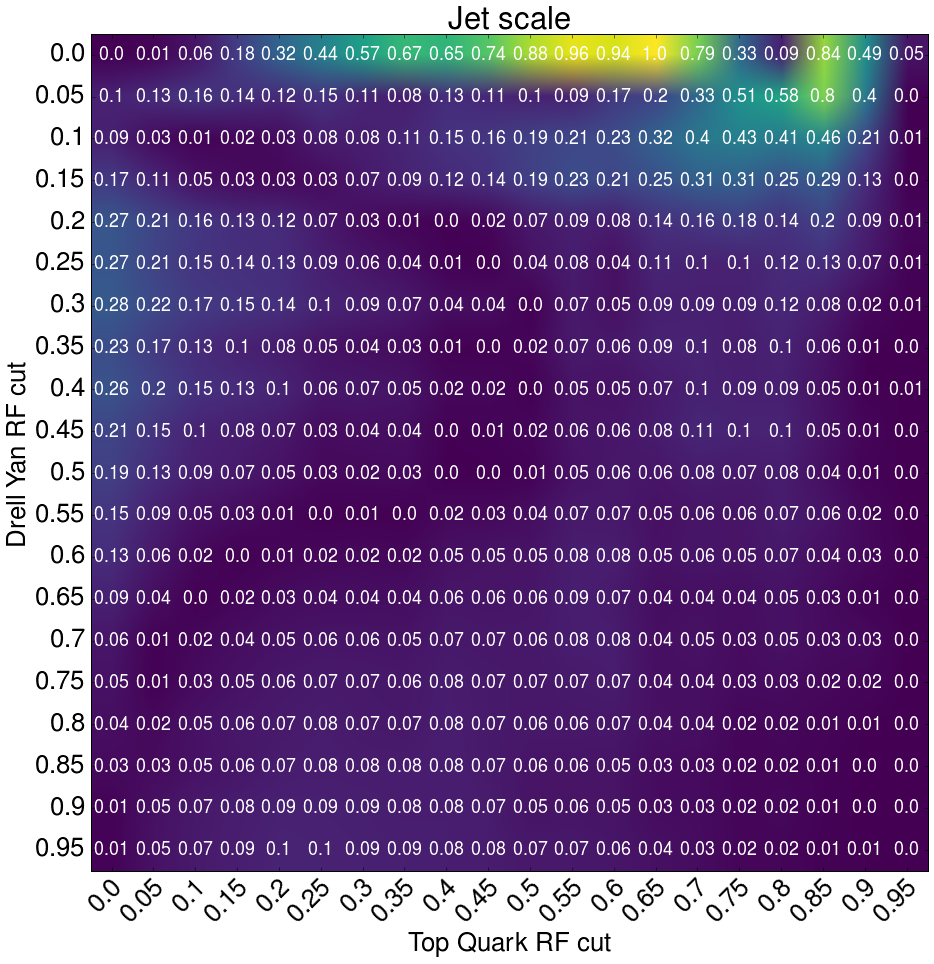

In [185]:
#Jet
plt.figure(figsize=(15,15))
plt.imshow(jet_array , cmap='viridis')
for i in range(jet_array.shape[0]):
    for j in range(jet_array.shape[1]):
        text = plt.text(j, i, round(jet_array[i, j] / jet_array.max(), 2),
                       ha="center", va="center", color="w", fontsize=18)
locs, labels= plt.xticks(np.arange(nbins), [float(i) / jet_array.shape[0] for i in range(jet_array.shape[0])])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.title("Jet scale")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.show()

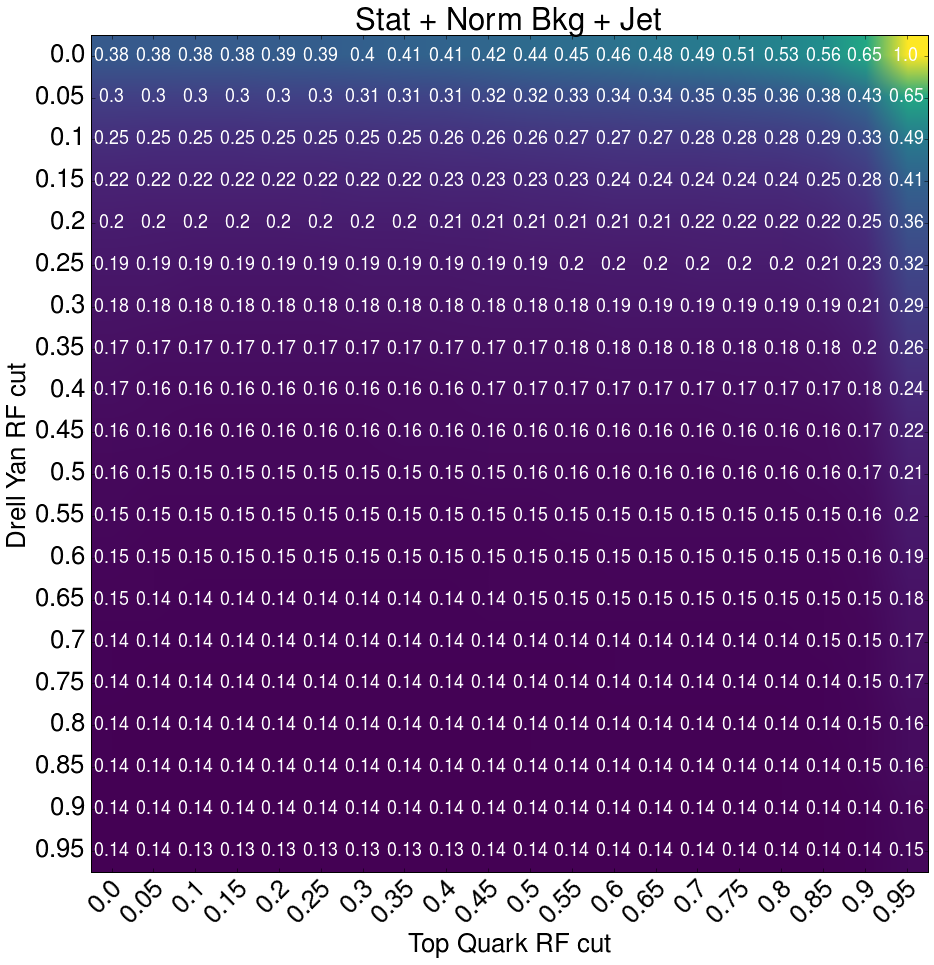

In [188]:
comb_array = (unc_norm_array**2 + unc_stat_array**2 + jet_array[i, j] / jet_array.max())**.5
plt.figure(figsize=(15,15))
plt.imshow(comb_array / comb_array.max(), cmap='viridis')
for i in range(unc_norm_array.shape[0]):
    for j in range(unc_norm_array.shape[1]):
        text = plt.text(j, i, round(comb_array[i, j] / comb_array.max(), 2),
                       ha="center", va="center", color="w", fontsize=18)
locs, labels= plt.xticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.title("Stat + Norm Bkg + Jet")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.show()

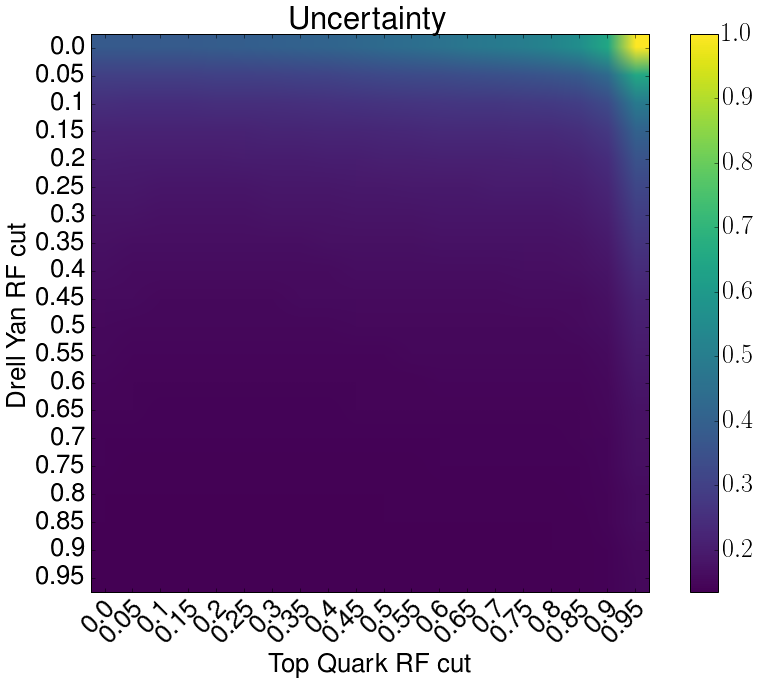

In [193]:
comb_array = (unc_norm_array**2 + unc_stat_array**2 + jet_array[i, j] / jet_array.max())**.5
plt.figure(figsize=(15,10))
plt.imshow(comb_array / comb_array.max(), cmap='viridis')
plt.colorbar()


locs, labels= plt.xticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.title("Uncertainty")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.savefig("/home/gunter/WW_analysis/PAPER/myDir/notes/AN-17-169/trunk/FIGS/plots/rf_unc.pdf")
plt.show()

## Njets test statistic

In [3]:
df_ww = df[df.process == "WW"]

In [4]:
def hist_jets(df):
    l = [0]*3
    jet_values = df.numb_jets.value_counts().values
    for i in range(jet_values.shape[0]):
        if i >=2:
            l[2] += float(jet_values[i])
        else:
            l[i] += float(jet_values[i])
    return np.array(l)

In [5]:
def hist_chi(expected, hist2):
    return ((expected - hist2)**2 / expected).sum()

In [6]:
chi_array = []
nbins = 20
for _fdy in range(0, nbins):
    chi_array.append([])
    for _ftt in range(0,nbins):
        fdy = float(_fdy) / nbins
        ftt = float(_ftt) / nbins
        
        a = hist_jets(df_ww)
        a = a / a.sum()
        b = hist_jets(df_ww[(df_ww.pred_fDY_WW > fdy) & (df_ww.pred_fTT_WW > ftt)])
        b = b / b.sum()
        
        chi_array[_fdy].append(hist_chi(a,b))
chi_array = np.array(chi_array)

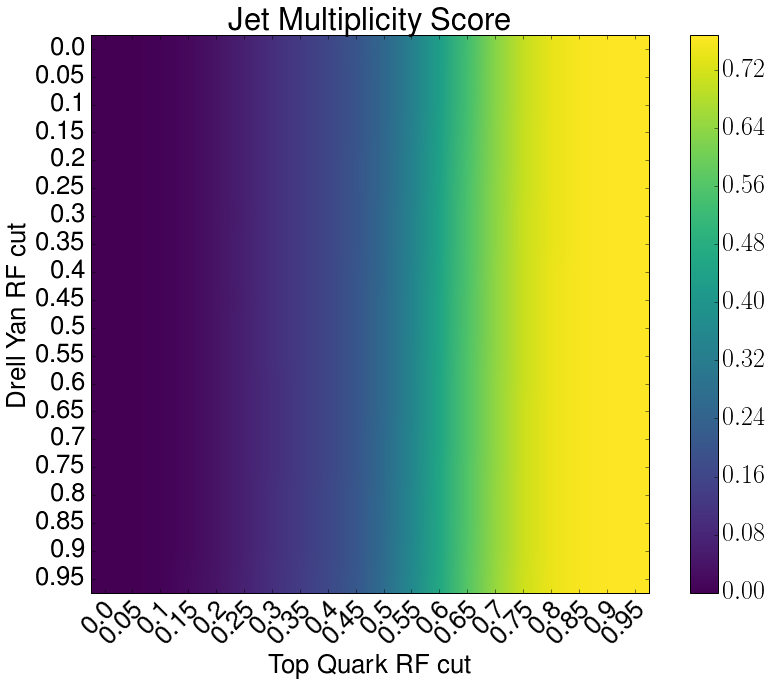

In [12]:
plt.figure(figsize=(15,10))
plt.imshow(chi_array, cmap='viridis')
plt.colorbar()
#for i in range(chi_array.shape[0]):
#    for j in range(chi_array.shape[1]):
#        text = plt.text(j, i, round(chi_array[i, j], 2),
#                       ha="center", va="center", color="w", fontsize=18)
locs, labels= plt.xticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.setp(labels, rotation=45, ha="right",
         rotation_mode="anchor")
plt.yticks(np.arange(nbins), [float(i) / 20. for i in range(nbins)])
plt.title("Jet Multiplicity Score")
plt.ylabel("Drell Yan RF cut")
plt.xlabel("Top Quark  RF cut")
plt.savefig("/home/gunter/WW_analysis/PAPER/myDir/notes/AN-17-169/trunk/FIGS/plots/rf_jet_m_s.pdf")
plt.show()

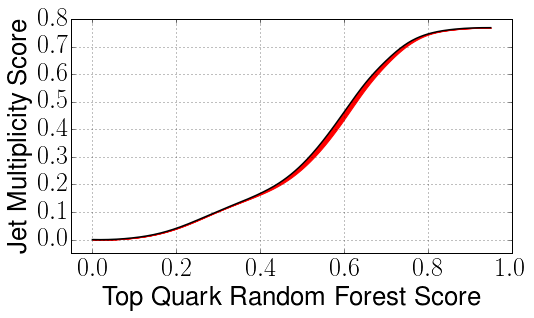

In [45]:
from scipy.interpolate import spline

plt.figure(figsize=(8,5))
xnew = np.linspace(0, 0.95,300) #300 represents number of points to make between T.min and T.max

nominal = spline([i / 20. for i in range(20)],chi_array[18],xnew)
down = spline([i / 20. for i in range(20)], chi_array[2], xnew)
up = spline([i / 20. for i in range(20)], chi_array[10], xnew)

plt.plot(xnew, nominal, color="black", linewidth=1.5)
plt.fill_between(xnew, nominal, up, color="red")
plt.fill_between(xnew, nominal, down, color="red")
plt.grid(True)

plt.xlim(-0.05, 1.0)
plt.ylim(-0.05, 0.8)
plt.ylabel("Jet Multiplicity Score")
plt.xlabel("Top Quark Random Forest Score")
plt.tight_layout()
plt.savefig("/home/gunter/WW_analysis/PAPER/myDir/notes/AN-17-169/trunk/FIGS/plots/rf_jet_m_s2.pdf")
plt.show()